In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio

import os
from os import listdir
from os.path import isfile, join
from collections import deque

import PIL
from PIL import Image
from tensorflow.keras import layers
import time

from IPython import display

In [2]:
def norm_img(img):
    img = (img / 127.5) - 1
    return img
def load_images(data_dir, batch_size):
    image_shape = (32, 32, 3)
    sample_dim = (batch_size,) + image_shape
    sample = np.empty(sample_dim, dtype=np.float32)
    
    sample_imgs_paths = [join(data_dir, f) for f in listdir(data_dir) if 'png' in f]
    for index,img_filename in enumerate(sample_imgs_paths):
        image = Image.open(img_filename)
        image = image.resize(image_shape[:-1])
        image = image.convert('RGB')
        image = np.asarray(image)
#         image = norm_img(image)
        sample[index,...] = image
    return sample

def preocess_imge(images):
    images.reshape(images.shape[0], 32, 32, 3).astype('int8')
    images /= 255.
    images[images  >= .5] = 1.
    images[images < .5] = 0.
    return images
def get_batch_image(images, batch_size, IMAGE_SHAPE):
    np.random.shuffle(images)
    return [images[i*batch_size : (i+1) *batch_size] for i in range(images.shape[0] // batch_size)]

IMAGE_SHAPE = (32, 32, 3)
data_dir = './input_source_word/'
BATCH_SIZE = 100
train_images = preocess_imge(load_images(data_dir, BATCH_SIZE))
test_images = preocess_imge(load_images(data_dir, BATCH_SIZE))

(100, 32, 32, 3)

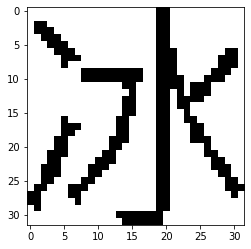

In [3]:
plt.imshow(train_images[0])
train_images.shape

In [5]:
def generate_and_save_images(output_dir, epoch, test_input):
    predictions = sample(decoder, test_input)
    fig = plt.figure(figsize=(4,4))

    for i in range(1):
        plt.subplot(1, 1, i+1)
        plt.imshow(predictions[i, :, :, :])
        plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('{}image_at_epoch_{:04d}.png'.format(output_dir, epoch))
    plt.show()

In [4]:
def encode(encoder, x):
    mean, logvar = tf.split(encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

def reparameterize(mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

def decode(decoder, z, apply_sigmoid=False):
    logits = decoder(z)
    if apply_sigmoid:
        probs = tf.sigmoid(logits)
        return probs
    return logits

In [6]:
discriminator = tf.keras.models.load_model('./model/discriminator50.h5')

encoder = tf.keras.models.load_model('./model/encoder50.h5')

decoder = tf.keras.models.load_model('./model/decoder50.h5')

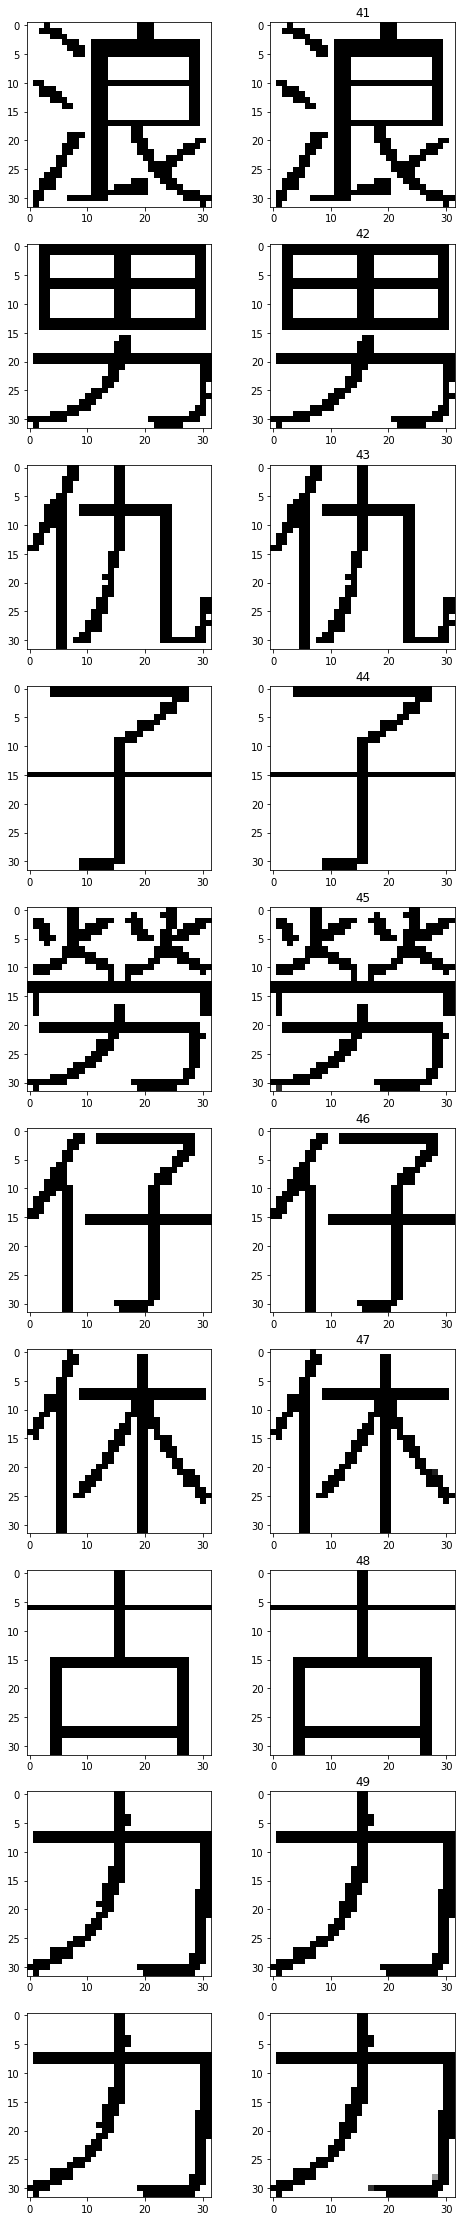

In [32]:
def to_grey(rgb):
     return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

plt.figure(figsize=(8,40))
begin = 40
end = 50
i = begin
while i < min(end, len(train_images)):
    x = train_images[i:i+1]
    mean, logvar = encode(encoder, x)
    z = reparameterize(mean, logvar)
    gen_imge = decode(decoder, z)
    plt.title(str(i))
    plt.subplot(end-begin, 2, 2*(i-begin)+1)
    plt.imshow(x[0,:,:,:])
    plt.subplot(end-begin, 2, 2*(i-begin)+2)
    plt.imshow(to_grey(gen_imge[0,:,:,:]), cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    i += 1

In [46]:
def get_diff_vector(x, y):
    mean, logvar = encode(encoder, x)
    z1 = reparameterize(mean, logvar)
    
    mean, logvar = encode(encoder, y)
    z2 = reparameterize(mean, logvar)
    return z2- z1

def change_from(source, target, step):
    output_dir = './moving_output/'
    mean, logvar = encode(encoder, source)
    z = reparameterize(mean, logvar)
    
    w = get_diff_vector(source, target)
    
    fig = plt.figure(figsize=(5, 5))
    for i in range(2 * step):
        if i < step:
            z += (1.0 / step) * w
        else:
            z -= (1.0 / step) * w
        gen_imge = decode(decoder, z)
        plt.imshow(to_grey(gen_imge[0,:,:,:]), cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
        plt.savefig('{}image_at_epoch_{}.png'.format(output_dir, str(i)))


In [47]:
x = train_images[71:72]
mean, logvar = encode(encoder, x)
z = reparameterize(mean, logvar)
print(z.shape, x.shape)

(1, 50) (1, 32, 32, 3)


In [ ]:
import warnings
warnings.filterwarnings("ignore")

source, target = train_images[71:72], train_images[41:42]
change_from(source, target, 100)

In [42]:
anim_file = 'cvae_girl_men.gif'
output_dir = './moving_output/'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}*.png'.format(output_dir))
    filenames = sorted(filenames, key = lambda x : int(x.replace('.png', '').split('_')[-1]))
    last = -1
    for i,filename in enumerate(filenames):
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
if IPython.version_info >= (6,2,0,''):
    display.Image(filename=anim_file)